In [1]:
import numpy as np
import pandas as pd
from dside import DSI
import matplotlib.pyplot as plt
import GPy
from smt.sampling_methods import LHS
from kernel_opt_fun import *

In [2]:
# step 1. Mathematical problem formulation
# Define the objective function which can be any 3D function
def f(X):
    # modified Gomez function from Geremia (2024)
    return (-np.sin(4 * np.pi * X[:, 0])) + 2 * (np.sin(2 * np.pi * X[:, 1]))**2 - 4 * (np.sin(np.pi*X[:, 2]))**3

In [3]:
#step 2. Surrogate model training
#Generate LHS training samples
xlimits = np.array([
    [-1,1],
    [-1,1],
    [-1,1],
])
sampling = LHS(xlimits=xlimits, criterion='ese')

n = 75 # the size of the training set is user defined, 100*D gives high fidelity surrogate model

x_LHS = sampling(n)

# Create input X arrays
X1 = x_LHS[:,0]
X2 = x_LHS[:,1]
X3 = x_LHS[:,2]

In [4]:

X = np.vstack((X1.flatten(), X2.flatten(), X3.flatten())).T
Y = f(X).reshape(-1, 1)

# Kernel optimisation 
best_kernel, best_mea = find_best_kernel(X, Y, input_dim=3)
print("Best kernel:", kernel_to_str(best_kernel))
print("Best MEA:", best_mea)
#GPR training 
model = GPy.models.GPRegression(X, Y, best_kernel)


reconstraining parameters std_periodic.lengthscale
reconstraining parameters std_periodic.variance
reconstraining parameters std_periodic.period


Kernel: rbf + rbf_1, MAE: 1.3312076457634747
Kernel: rbf * rbf_1, MAE: 1.3312076710078864
Kernel: rbf + linear, MAE: 1.3312077817365797
Kernel: rbf * linear, MAE: 1.4243169983614647
Kernel: rbf + RatQuad, MAE: 1.331208261536826
Kernel: rbf * RatQuad, MAE: 1.3312035189351359
Kernel: rbf + std_periodic, MAE: 1.2374061433484078
Kernel: rbf * std_periodic, MAE: 0.5456895443716855
Kernel: linear + rbf, MAE: 1.3312077817365797
Kernel: linear * rbf, MAE: 1.424316998361465
Kernel: linear + linear_1, MAE: 1.6695781082464145
Kernel: linear * linear_1, MAE: 2.007525317484441
Kernel: linear + RatQuad, MAE: 1.3312336631706572
Kernel: linear * RatQuad, MAE: 1.4242670790440182
Kernel: linear + std_periodic, MAE: 1.1904258995300843
Kernel: linear * std_periodic, MAE: 1.5285887737199246
Kernel: RatQuad + rbf, MAE: 1.3312082615368512
Kernel: RatQuad * rbf, MAE: 1.3312035189351312
Kernel: RatQuad + linear, MAE: 1.3312290785872374
Kernel: RatQuad * linear, MAE: 1.4242997603131562
Kernel: RatQuad + RatQuad

 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad + rbf, MAE: 0.6527066494009187


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * rbf, MAE: 0.5457108967251616
Kernel: std_periodic * RatQuad + linear, MAE: 0.5393025470677452


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * linear, MAE: 0.9742799048749237


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad + RatQuad, MAE: 0.5457086011526319


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * RatQuad_1, MAE: 0.5456493382470771


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad + std_periodic, MAE: 0.13670375680694932


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1, MAE: 0.11576819534517044


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + rbf, MAE: 0.11578823772884327


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 * rbf, MAE: 0.11576489010263437


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + linear, MAE: 0.10751514815993432


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 * linear, MAE: 1.1991029247404739


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + RatQuad, MAE: 0.11578317180254792


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 * RatQuad_1, MAE: 0.11576312370157434


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic, MAE: 0.008873150146205593


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 * std_periodic_2, MAE: 0.609698667816215


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic + rbf, MAE: 0.008865873926264181


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * rbf, MAE: 0.004010838596908954


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic + linear, MAE: 0.005710869282355971


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * linear, MAE: 1.5924989500360973


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic + RatQuad, MAE: 0.00633869141433027


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * RatQuad, MAE: 0.006724360281073349


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic + std_periodic_1, MAE: 0.008855687306837152


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * std_periodic, MAE: 0.014542479160512012


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * rbf + rbf, MAE: 0.0040168595903294175


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * rbf * rbf_1, MAE: 0.004017143198350278


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * rbf + linear, MAE: 0.014205321707072302


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * rbf * linear, MAE: 1.0416358309938214


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * rbf + RatQuad, MAE: 0.003980938565223658


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * rbf * RatQuad, MAE: 0.0040045190654067675


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * rbf + std_periodic, MAE: 0.004276341672581248


 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * rbf * std_periodic, MAE: 0.006397625723311396

Results of each iteration:
Iteration 1: Best Kernel: std_periodic * RatQuad, MAE: 0.54566
Iteration 2: Best Kernel: std_periodic * RatQuad * std_periodic_1, MAE: 0.11577
Iteration 3: Best Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic, MAE: 0.00887
Iteration 4: Best Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * rbf, MAE: 0.00401
Iteration 5: Best Kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * rbf + RatQuad, MAE: 0.00398
Best kernel: std_periodic * RatQuad * std_periodic_1 + std_periodic * rbf + RatQuad
Best MEA: 0.003980938565223658


In [5]:
### uncomment for plotting without optimisation
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# # Define a collection of kernels to test
# kernels = [ GPy.kern.RBF(input_dim=3), ]

# # Perform cross-validation to select the best kernel
# best_kernel = None
# best_mse = float('inf')

# for kernel in kernels:
#     model = GPy.models.GPRegression(X_train, Y_train, kernel)
#     model.optimize()
    
#     Y_pred, _ = model.predict(X_test)
#     mse = mean_squared_error(Y_test, Y_pred)
    
#     print(f"Kernel: {kernel.name}, MSE: {mse}")
#     if mse < best_mse:
#         best_mse = mse
#         est_kernel = kernel

# print(" Best MSE: {best_mse}")

# # Retrain on the whole dataset with the best kernel
# model = GPy.models.GPRegression(X, Y, best_kernel)

In [6]:
#using the GPy function optimize hyperparameters are optimized for a better fit
model.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0008   2.280789e+04   1.901713e+11 

 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



    01s33  0065  -2.394991e+01   9.837154e-04 
Runtime:     01s33
Optimization status: Converged



In [7]:

# # Re-generate sample points for plotting (finer grid)

#linspace resampling is best for plotting
n = 50  # user defined, would generate n^D samples
X1 = np.linspace(-1, 1, n) 
X2 = np.linspace(-1, 1, n)
X3 = np.linspace(-1, 1, n)
X1, X2, X3 = np.meshgrid(X1, X2, X3) 

X = np.vstack((X1.flatten(), X2.flatten(), X3.flatten())).T
Y = f(X).reshape(-1, 1)
#predicting Y values based on the trained GP
X_pred = X
Y_pred, Y_pred_var = model.predict(X_pred)
# Reshape for plotting
Y_pred = Y_pred.reshape(X1.shape)
Y_true = f(X_pred).reshape(X1.shape)

In [8]:
#Surrogate metrics
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error 

MAE = mean_absolute_error(Y,  Y_pred.reshape(-1, 1))
MAPE = mean_absolute_percentage_error(Y,  Y_pred.reshape(-1, 1))
print(f"MAE = {MAE:.5f}")
#print(f"MAPE = {MAPE*100:.2f}%") #uncomment if using MAPE from sklearn instead of the custom MAPE




MAE = 0.00225


In [9]:
# #uncomment this cell if using the MAPE from the sklearn package and it comes out unproportionally large
# # #helps investigate large MAPE by calculating the % of near zero Y that can cause it
# # Plot the distribution of Y_true
# plt.hist(Y, bins=50, edgecolor='black')
# plt.title("Distribution of True Values (Y_true)")
# plt.xlabel("Y_true")
# plt.ylabel("Frequency")
# plt.show()
# # Calculate the percentage of small values baaed on Ytrue
# threshold = 1e-3
# percentsmallY = percentage_small_values(Y, threshold)

# print(f"Percentage of small true values (|Y_true| < {threshold}): {percentsmallY:.2f}%")

In [10]:
# Calculate custom MAPE (includes a small constant to account for near zero values)
custom_MAPE = custom_mape(Y,  Y_pred.reshape(-1, 1))
print(f"Custom MAPE = {custom_MAPE:.5f}%")

Custom MAPE = 1.22040%


In [11]:
#surrogate model metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
R2score = r2_score(Y,  Y_pred.reshape(-1, 1))
MSE = mean_squared_error(Y,  Y_pred.reshape(-1, 1))
print(f"R2 = {R2score:.2f}")
print(f"MSE = {MSE:.5f}")

R2 = 1.00
MSE = 0.00001


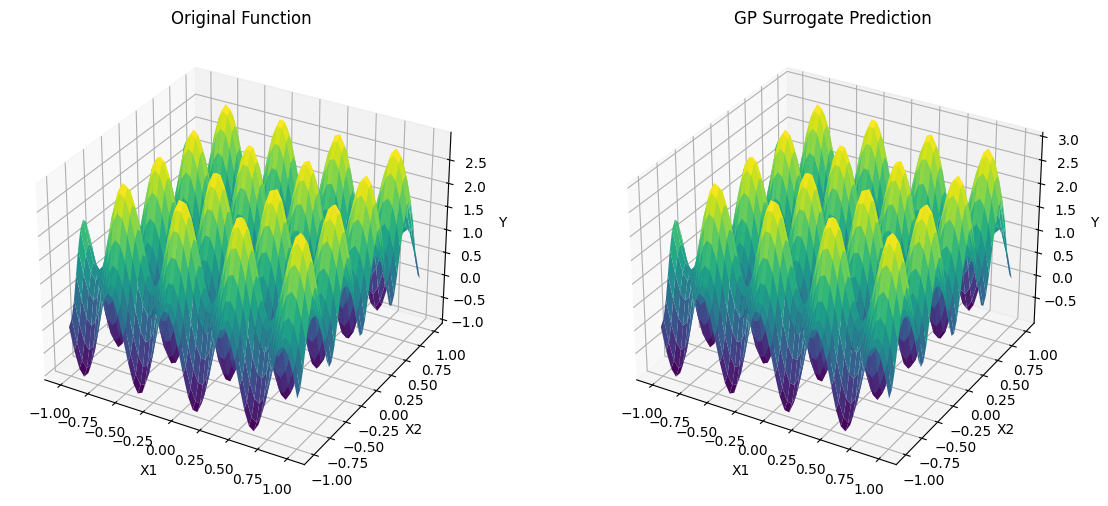

In [12]:
# Plotting of the original vs surrogate 
# Note: Plotting a 3D surface is not directly possible for 4D data (X1, X2, X3, Y).
# So we will plot slices or projections. here we plot a slice where X3 is fixed.

# Select a fixed slice for X3 = 0 for visualization
slice_index = n // 2
X1_slice = X1[:, :, slice_index]
X2_slice = X2[:, :, slice_index]
Y_true_slice = Y_true[:, :, slice_index]
Y_pred_slice = Y_pred[:, :, slice_index]
residuals = Y_true_slice - Y_pred_slice
# Plotting
fig = plt.figure(figsize=(14, 6))

# Original data
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1_slice, X2_slice, Y_true_slice, cmap='viridis')
ax1.set_title('Original Function')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('Y')

# Surrogate model prediction
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1_slice, X2_slice, Y_pred_slice, cmap='viridis')
ax2.set_title('GP Surrogate Prediction')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('Y')

plt.show()


In [13]:
# # residuals 2D plots
# # Compare Y_true and Y_pred visually
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Y_true Slice")
# plt.contourf(X1_slice, X2_slice, Y_true_slice, cmap='viridis')
# plt.colorbar()

# plt.subplot(1, 2, 2)
# plt.title("Y_pred Slice")
# plt.contourf(X1_slice, X2_slice, Y_pred_slice, cmap='viridis')
# plt.colorbar()
# plt.show()

# # Plot residuals
# plt.figure(figsize=(6, 6))
# plt.title("Residuals (Y_true - Y_pred)")
# plt.contourf(X1_slice, X2_slice, residuals, cmap='coolwarm')
# plt.colorbar()
# plt.show()


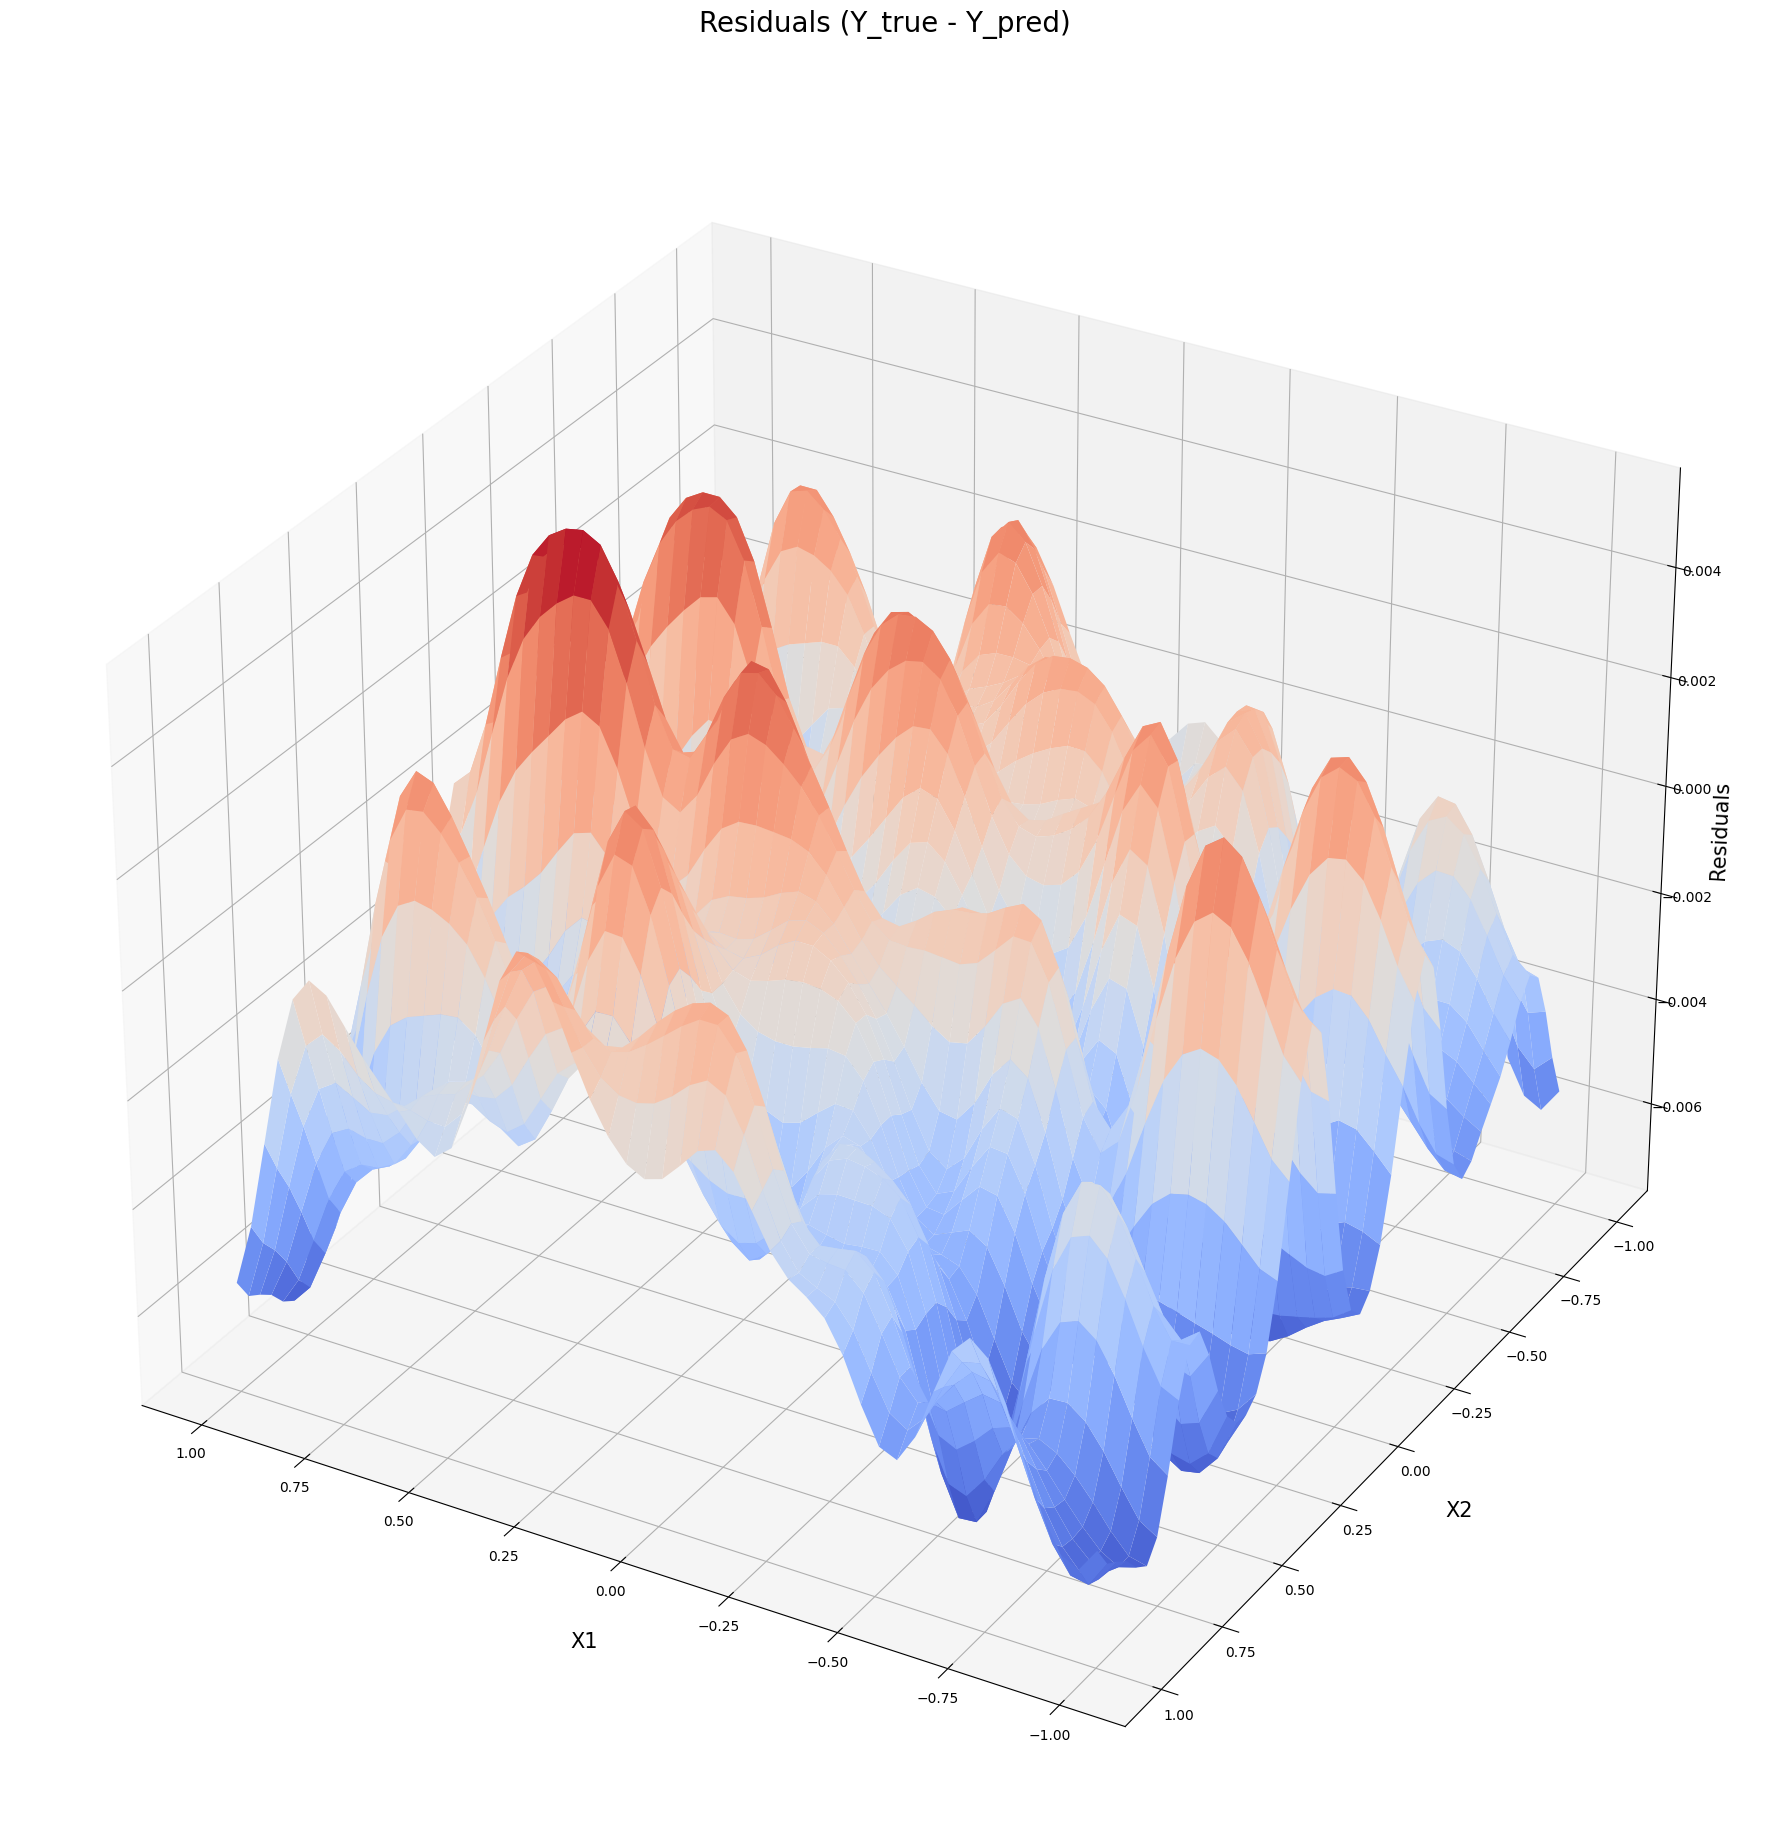

In [14]:
#residuals plotting 
fig = plt.figure(figsize=(25,25), dpi=100)
ax = fig.add_subplot(111, projection='3d')  # Changed to a single subplot

# Plotting
ax.plot_surface(X1_slice, X2_slice, residuals, cmap='coolwarm')
ax.set_title('Residuals (Y_true - Y_pred)', fontsize=20, pad=40)  # Reduced font size and increased padding
ax.set_xlabel('X1', labelpad=20, fontsize=15)  # Increased labelpad and reduced font size
ax.set_ylabel('X2', labelpad=20, fontsize=15)  # Increased labelpad and reduced font size
ax.set_zlabel('Residuals', fontsize=15)  # Increased labelpad further and reduced font size

# Adjust subplot parameters to create more space on the right
plt.subplots_adjust(left=0.1, right=0.8, top=0.85, bottom=0.15)

# Rotate the view to better position the z-label
ax.view_init(elev=30, azim=120)  # Adjust the viewing angle as needed

# Display the plot
plt.show()



In [15]:

# Flatten the arrays
X1_flat = X1.flatten()
X2_flat = X2.flatten()
X3_flat = X3.flatten()
Y_true_flat = Y_true.flatten()
Y_pred_flat = Y_pred.flatten()

# Create a DataFrame
data = {
    'X1': X1_flat,
    'X2': X2_flat,
    'X3': X3_flat,
    'Y_true': Y_true_flat,
    'Y_pred': Y_pred_flat,
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

         X1   X2        X3        Y_true    Y_pred
0      -1.0 -1.0 -1.000000 -4.898587e-16  0.002552
1      -1.0 -1.0 -0.959184  8.364480e-03  0.011512
2      -1.0 -1.0 -0.918367  6.528120e-02  0.068540
3      -1.0 -1.0 -0.877551  2.113884e-01  0.214417
4      -1.0 -1.0 -0.836735  4.726664e-01  0.475444
...     ...  ...       ...           ...       ...
124995  1.0  1.0  0.836735 -4.726664e-01 -0.472702
124996  1.0  1.0  0.877551 -2.113884e-01 -0.210873
124997  1.0  1.0  0.918367 -6.528120e-02 -0.063674
124998  1.0  1.0  0.959184 -8.364480e-03 -0.005399
124999  1.0  1.0  1.000000  4.898587e-16  0.004071

[125000 rows x 5 columns]


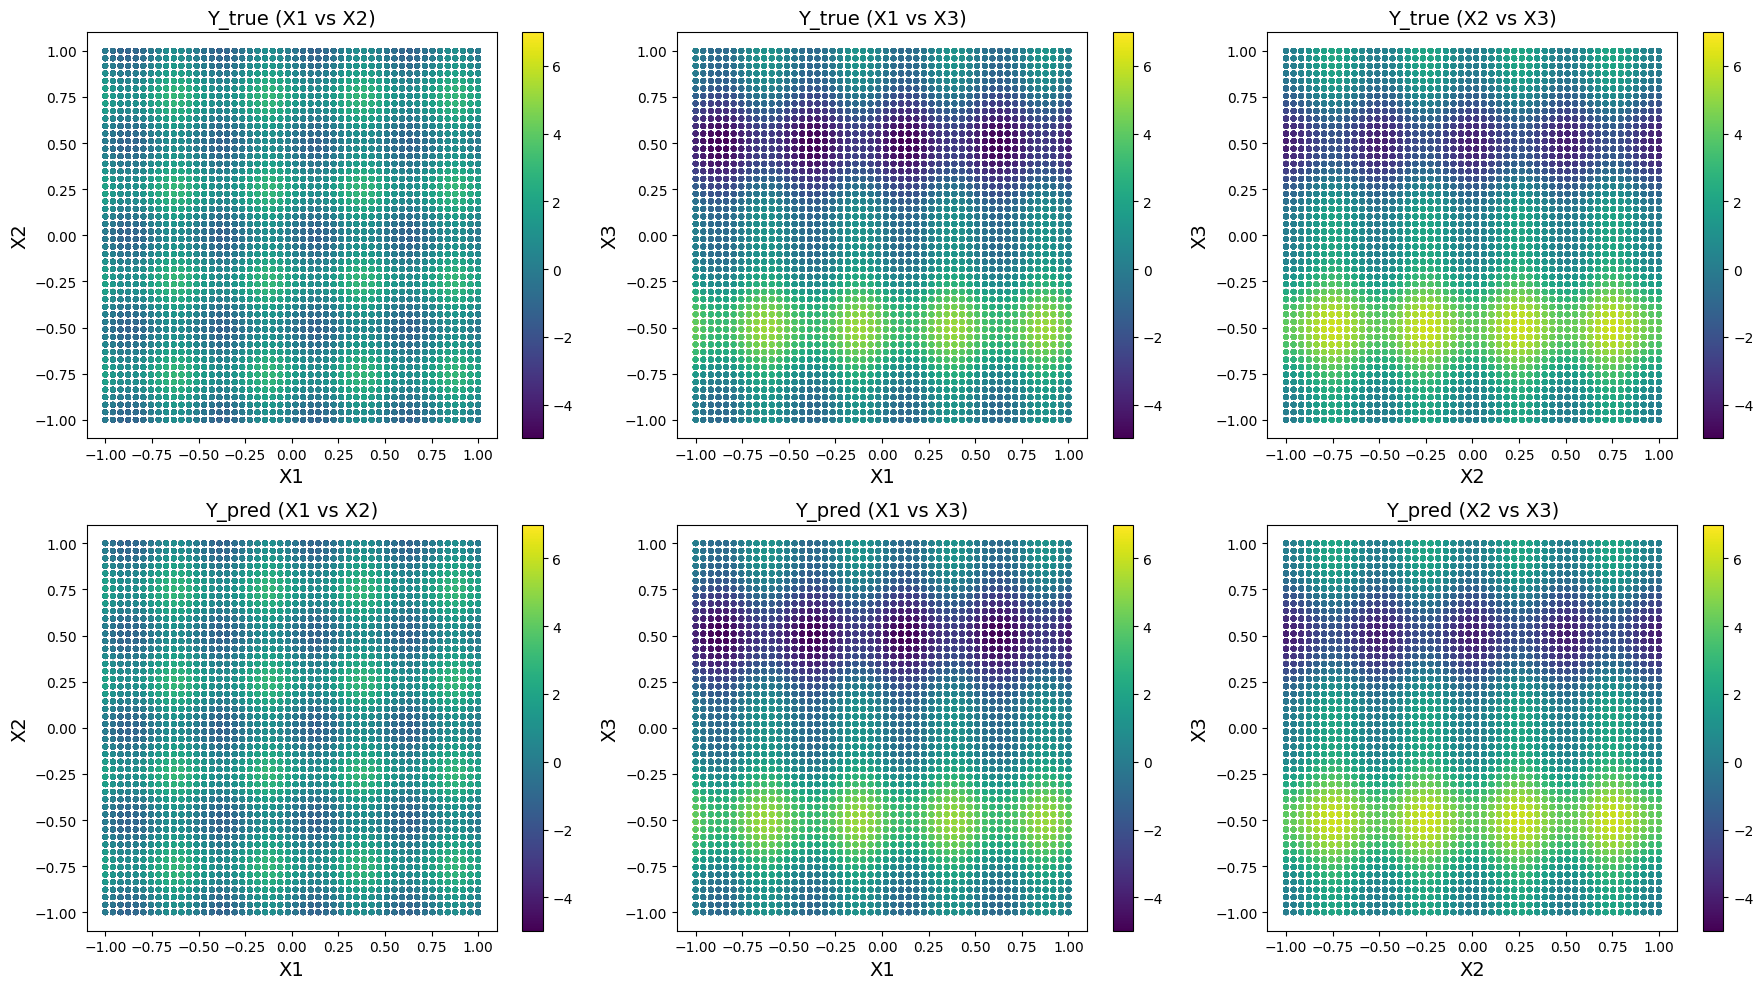

In [16]:

#uncomment for 2D plotting of Ytrue vs Ypred
Y_true = Y_true_flat
Y_pred = Y_pred_flat

fig, ax = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns layout for better visualization
fs = 14

# Plotting combinations for Y_true
sc1 = ax[0, 0].scatter(df['X1'], df['X2'], c=df['Y_true'], marker='.', cmap='viridis')
cbar1 = fig.colorbar(sc1, ax=ax[0, 0])
ax[0, 0].set_title('Y_true (X1 vs X2)', fontsize=fs)
ax[0, 0].set_xlabel('X1', fontsize=fs)
ax[0, 0].set_ylabel('X2', fontsize=fs)

sc2 = ax[0, 1].scatter(df['X1'], df['X3'], c=df['Y_true'], marker='.', cmap='viridis')
cbar2 = fig.colorbar(sc2, ax=ax[0, 1])
ax[0, 1].set_title('Y_true (X1 vs X3)', fontsize=fs)
ax[0, 1].set_xlabel('X1', fontsize=fs)
ax[0, 1].set_ylabel('X3', fontsize=fs)

sc3 = ax[0, 2].scatter(df['X2'], df['X3'], c=df['Y_true'], marker='.', cmap='viridis')
cbar3 = fig.colorbar(sc3, ax=ax[0, 2])
ax[0, 2].set_title('Y_true (X2 vs X3)', fontsize=fs)
ax[0, 2].set_xlabel('X2', fontsize=fs)
ax[0, 2].set_ylabel('X3', fontsize=fs)

# Plotting combinations for Y_pred
sc4 = ax[1, 0].scatter(df['X1'], df['X2'], c=df['Y_pred'], marker='.', cmap='viridis')
cbar4 = fig.colorbar(sc4, ax=ax[1, 0])
ax[1, 0].set_title('Y_pred (X1 vs X2)', fontsize=fs)
ax[1, 0].set_xlabel('X1', fontsize=fs)
ax[1, 0].set_ylabel('X2', fontsize=fs)

sc5 = ax[1, 1].scatter(df['X1'], df['X3'], c=df['Y_pred'], marker='.', cmap='viridis')
cbar5 = fig.colorbar(sc5, ax=ax[1, 1])
ax[1, 1].set_title('Y_pred (X1 vs X3)', fontsize=fs)
ax[1, 1].set_xlabel('X1', fontsize=fs)
ax[1, 1].set_ylabel('X3', fontsize=fs)

sc6 = ax[1, 2].scatter(df['X2'], df['X3'], c=df['Y_pred'], marker='.', cmap='viridis')
cbar6 = fig.colorbar(sc6, ax=ax[1, 2])
ax[1, 2].set_title('Y_pred (X2 vs X3)', fontsize=fs)
ax[1, 2].set_xlabel('X2', fontsize=fs)
ax[1, 2].set_ylabel('X3', fontsize=fs)

plt.tight_layout()
plt.show()


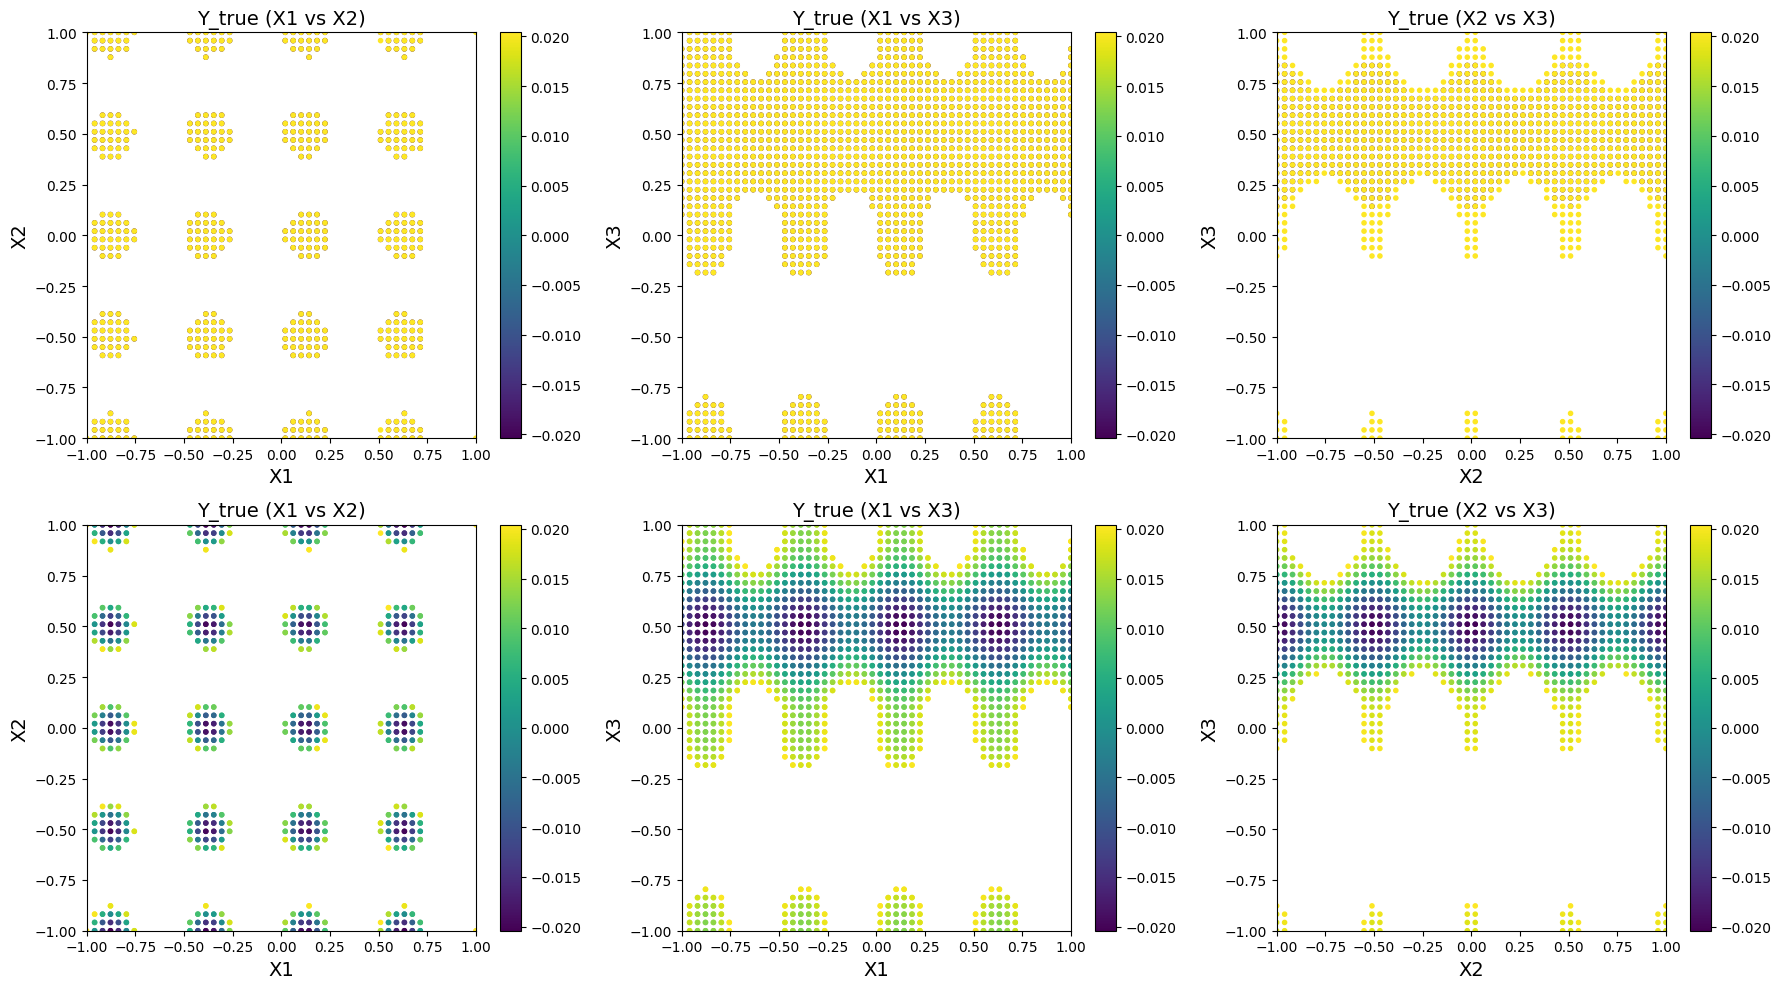

In [17]:
#uncomment for 2D plotting of Ytrue vs Ypred around one point of interest
#the plots can be used for cross checking later
#when adding Ypred pay attention that it is of shape (70,70)
ptol = 0.05 #tolerance from the pp
pp = 0 #user defined point of interest
fm_X1 = ((df['Y_true'] <= 0 ) & ((df['X1'] < pp + ptol) & (df['X1'] > pp - ptol)))
fm_X2 = ((df['Y_true'] <= 0 ) & ((df['X2'] < pp + ptol) & (df['X2'] > pp - ptol)))
fm_X3 = ((df['Y_true'] <= 0 ) & ((df['X3'] < pp + ptol) & (df['X3'] > pp - ptol)))

fig, ax = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns layout for better visualization
fs = 14

# Plotting combinations for Y_true
sc1 = ax[0, 0].scatter(df['X1'][fm_X3], df['X2'][fm_X3], c=df['X3'][fm_X3], marker='.', cmap='viridis')
cbar1 = fig.colorbar(sc1, ax=ax[0, 0])
ax[0, 0].set_title('Y_true (X1 vs X2)', fontsize=fs)
ax[0, 0].set_xlabel('X1', fontsize=fs)
ax[0, 0].set_ylabel('X2', fontsize=fs)
ax[0, 0].set_xlim([-1,1])
ax[0, 0].set_ylim([-1,1])

sc2 = ax[0, 1].scatter(df['X1'][fm_X2], df['X3'][fm_X2], c=df['X2'][fm_X2], marker='.', cmap='viridis')
cbar2 = fig.colorbar(sc2, ax=ax[0, 1])
ax[0, 1].set_title('Y_true (X1 vs X3)', fontsize=fs)
ax[0, 1].set_xlabel('X1', fontsize=fs)
ax[0, 1].set_ylabel('X3', fontsize=fs)
ax[0, 1].set_xlim([-1,1])
ax[0, 1].set_ylim([-1,1])

sc3 = ax[0, 2].scatter(df['X2'][fm_X1], df['X3'][fm_X1], c=df['X1'][fm_X1], marker='.', cmap='viridis')
cbar3 = fig.colorbar(sc3, ax=ax[0, 2])
ax[0, 2].set_title('Y_true (X2 vs X3)', fontsize=fs)
ax[0, 2].set_xlabel('X2', fontsize=fs)
ax[0, 2].set_ylabel('X3', fontsize=fs)
ax[0, 2].set_xlim([-1,1])
ax[0, 2].set_ylim([-1,1])

# Plotting combinations for Y_true
sc4 = ax[1, 0].scatter(df['X1'][fm_X3], df['X2'][fm_X3], c=df['Y_true'][fm_X3], marker='.', cmap='viridis')
cbar1 = fig.colorbar(sc1, ax=ax[1, 0])
ax[1, 0].set_title('Y_true (X1 vs X2)', fontsize=fs)
ax[1, 0].set_xlabel('X1', fontsize=fs)
ax[1, 0].set_ylabel('X2', fontsize=fs)
ax[1, 0].set_xlim([-1,1])
ax[1, 0].set_ylim([-1,1])

sc5 = ax[1, 1].scatter(df['X1'][fm_X2], df['X3'][fm_X2], c=df['Y_true'][fm_X2], marker='.', cmap='viridis')
cbar2 = fig.colorbar(sc2, ax=ax[1, 1])
ax[1, 1].set_title('Y_true (X1 vs X3)', fontsize=fs)
ax[1, 1].set_xlabel('X1', fontsize=fs)
ax[1, 1].set_ylabel('X3', fontsize=fs)
ax[1, 1].set_xlim([-1,1])
ax[1, 1].set_ylim([-1,1])

sc6 = ax[1, 2].scatter(df['X2'][fm_X1], df['X3'][fm_X1], c=df['Y_true'][fm_X1], marker='.', cmap='viridis')
cbar3 = fig.colorbar(sc3, ax=ax[1, 2])
ax[1, 2].set_title('Y_true (X2 vs X3)', fontsize=fs)
ax[1, 2].set_xlabel('X2', fontsize=fs)
ax[1, 2].set_ylabel('X3', fontsize=fs)
ax[1, 2].set_xlim([-1,1])
ax[1, 2].set_ylim([-1,1])

plt.tight_layout()
plt.show()

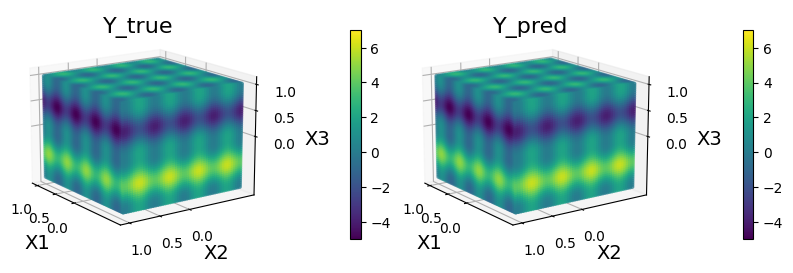

In [18]:
# uncomment for 3D plotting of Ytrue vs Ypred
fs = 14
fig = plt.figure(figsize = (8, 3))
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
s1 = ax1.scatter(X1, X2, X3, c = Y_true, marker = '.')
cbar1 = fig.colorbar(s1, ax = ax1, fraction = 0.03, pad = 0.25)
ax1.view_init(15, 145)
ax1.set_title('Y_true', fontsize = fs + 2, y = 0.95)
ax1.set_xlabel('X1', fontsize = fs)
ax1.set_ylabel('X2', fontsize = fs)
ax1.set_zlabel('X3', fontsize = fs)
ax1.set_xticks([0, 0.5, 1])
ax1.set_yticks([0, 0.5, 1])
ax1.set_zticks([0, 0.5, 1])

ax2 = fig.add_subplot(1, 2, 2, projection = '3d')
s2 = ax2.scatter(X1, X2, X3, c = Y_pred, marker = '.')
cbar2 = fig.colorbar(s2, ax = ax2, fraction = 0.03, pad = 0.25)
ax2.view_init(15, 145)
ax2.set_title('Y_pred', fontsize = fs + 2, y = 0.95)
ax2.set_xlabel('X1', fontsize = fs)
ax2.set_ylabel('X2', fontsize = fs)
ax2.set_zlabel('X3', fontsize = fs)
ax2.set_xticks([0, 0.5, 1])
ax2.set_yticks([0, 0.5, 1])
ax2.set_zticks([0, 0.5, 1])

plt.tight_layout()
plt.show()

In [19]:
# ### uncomment for 3D plotting of DSp
# # Define our design input labels
# vn = ['X1', 'X2', 'X3']

# # Define the Y constraints as a dictionary
# # the keys corresponds to the column of the dataframe
# u = -0

# constraints = {'Y_pred': [-1e20, u]} #no additional constraints the function itself is <0
# # Initialize the design space entity
# ds = DSI(df)
# # Apply the constraints separating the satisfied and violated points
# ds.screen(constraints)
# # Finding the design space (alpha shape)
# ds.find_DSp(vn)


In [20]:
# # Plot the design space
# ds.plot()

# # We can extract matplotlib ax and figure from the class
# fig = ds.fig
# ax = ds.ax
# # Rotate the plot 
# ax.view_init(30, -120)
# ax.set_xticks([0, 0.5, 1])
# ax.set_yticks([0, 0.5, 1])
# ax.set_zticks([0, 0.5, 1])
# plt.show()

# # Check if there are any violated points in the design space
# print('Check for violations inside design space:')
# print(ds.vindsp)

In [21]:

#GP mathematical model function for slicing later
#step 3. Surrogate model simulation
def Gomez3D(X):
    Y_pred, Y_pred_var = model.predict(X)
    X1 = np.array(X[:,0])
    X2 = np.array(X[:,1])
    X3 = np.array(X[:,2])
    Y_true = np.array((-np.sin(4 * np.pi * X1)) + 2 * (np.sin(2 * np.pi * X2))**2 - 4 * (np.sin(np.pi*X3))**3)

    X1_flat = X1.flatten()
    X2_flat = X2.flatten()
    X3_flat = X3.flatten()
    Y_true_flat = Y_true.flatten()
    Y_pred_flat = Y_pred.flatten()

    # Create a DataFrame
    data = {
        'X1': X1_flat,
        'X2': X2_flat,
        'X3': X3_flat,
        'Y_true': Y_true_flat,
        'Y_pred': Y_pred_flat,
    }
    df = pd.DataFrame(data)
    return df


In [22]:
#step 4. DSp identification
#DSp with the slicing tool

#declaring the problem info 
# Global variables
maxvp = 0

cons = {'Y_pred': [-1e20, 0]} 
benchmark_problems = {'Gomez3D':    Gomez3D}
sv3D = ['X1', 'X2', 'X3']
problem_sv = {'Gomez3D':    sv3D}


problem_list = ['Gomez3D']
opt_hidedsp = {'hidedsp': True, 'hidevio': True}
no_samples = 4096
#no_slices = 1
benchmark_sol_3DGP = {}

#nominal point for analysis
NP = [0, 0, 0] #midranges

opt_find_DSp = {'hidedsp': False, 'opt_amul': True, 'maxvp': maxvp, 'tol': -1e5, 'ub': 1, 'lb': 0}

In [23]:
    
def get_XconstNP(constant_dict, sv, lb, ub, no_samples, sampling_method, F_sam_plot):
    import numpy as np
    index_cut = []
    index_constant = []
    for l in sv:
        if l not in list(constant_dict.keys()):
            index_cut.append(sv.index(l))
        else:
            index_constant.append(sv.index(l))

    lb_cut = np.array(lb)[index_cut]
    ub_cut = np.array(ub)[index_cut]
    sv_cut = (np.array(sv)[index_cut]).tolist()

    Xcut = Sobol_sequence(lb_cut, ub_cut)
    Xnew = np.zeros((Xcut.shape[0], len(sv)))
    Xnew[:, index_cut] = Xcut
    Xnew[:, index_constant] = np.array([constant_dict[l] for l in list(constant_dict.keys())])
    return Xnew, sv_cut

def get_slices_dfNP(no_slices, sv, lb, ub, no_samples, sampling_method, F_sam_plot, f, NP):
    import numpy as np
    import pandas as pd
    all_slices = []
    for slice_no in no_slices:
        constant_vars = sv[slice_no]
        index_cut = []
        index_constant = []

        for l in sv:
            if l not in constant_vars:
                index_cut.append(sv.index(l))
            else:
                index_constant.append(sv.index(l))
        
        sv_constant = (np.array(sv)[index_constant]).tolist() 
        #assigning value to the constant from the declared point
        X_constant = []
        X_constant.append(NP[slice_no])
        
        
    
        constant_dict = {}
        for i, l in enumerate(sv_constant):
            constant_dict[l] = X_constant[i]
        Xnew, sv_cut = get_XconstNP(constant_dict, sv, lb, ub, no_samples, sampling_method, F_sam_plot)

        df = f(Xnew)
        df.insert(0, 'sv_cut', [sv_cut for i in range(df.shape[0])])
        df.insert(0, 'slice_no', slice_no)
        all_slices.append(df)
            
    all_slices = pd.concat(all_slices).reset_index(drop = True)
    return all_slices 

In [24]:
#iterating through the slices

for problem_label in problem_list:
    print(problem_label)
    benchmark_sol_3DGP[problem_label] = {}
    f = benchmark_problems[problem_label]
    sv = problem_sv[problem_label]
    lb = xlimits[:,0]
    ub = xlimits[:,1]
    
    no_slices = range(len(sv))
    
    df_slices = get_slices_dfNP(no_slices, sv, lb, ub, no_samples, 'sobol', False, f, NP)
    for slice in no_slices:
        df = df_slices.copy()
        df = df[df['slice_no'] == slice]
        sv_slice = df['sv_cut'].iloc[0]
        
        ds = DSI(df)
        ds.screen(cons)
        ds.vnames = sv_slice
        ds.opt.update(opt_hidedsp)
        print(ds.df)
        if ds.sat.shape[0] == 0:
            print('No feasible points in slice ' + str(slice))
        else:
            #ds.find_DSp(sv_slice, opt = opt_find_DSp)
            #ds.plot(opt = {'hidevio': False})
            # Uncomment the above to find the DSp for each slice
            pass
        benchmark_sol_3DGP[problem_label][slice] = ds
save_pkl(benchmark_sol_3DGP, 'benchmark_sol_3DGP.pkl')

Gomez3D
      slice_no    sv_cut   X1        X2       X3        Y_true    Y_pred  \
0            0  [X2, X3]  0.0 -1.000000 -1.00000  1.199808e-31  0.002223   
1            0  [X2, X3]  0.0  0.000000  0.00000  0.000000e+00  0.002595   
2            0  [X2, X3]  0.0  0.500000 -0.50000  4.000000e+00  4.000705   
3            0  [X2, X3]  0.0 -0.500000  0.50000 -4.000000e+00 -3.995973   
4            0  [X2, X3]  0.0 -0.250000 -0.25000  3.414214e+00  3.413574   
...        ...       ...  ...       ...      ...           ...       ...   
8187         0  [X2, X3]  0.0 -0.249756  0.81665  1.353614e+00  1.351007   
8188         0  [X2, X3]  0.0 -0.499756 -0.43335  3.743587e+00  3.742309   
8189         0  [X2, X3]  0.0  0.500244  0.56665 -3.743577e+00 -3.738033   
8190         0  [X2, X3]  0.0  0.000244 -0.93335  3.592859e-02  0.039979   
8191         0  [X2, X3]  0.0 -0.999756  0.06665 -3.591918e-02 -0.035785   

     SatFlag  
0      False  
1      False  
2      False  
3       True  
4   

In [25]:
#metrics 

benchmark_sol_3DGP = load_pkl('benchmark_sol_3DGP.pkl')

for no_slice in range(len(list(benchmark_sol_3DGP[problem_label].keys()))):
        print('slice #',no_slice)
        ds = benchmark_sol_3DGP[problem_label][no_slice]
        YpredFlag = np.array(ds.df['SatFlag'], dtype=int)
        Ytrue = np.array(ds.df['Y_true'])
        YtrueFlag = np.where((Ytrue >= cons['Y_pred'][0]) & (Ytrue <= cons['Y_pred'][1]), 1, 0)
        metrics = evaluate_metrics(YtrueFlag, YpredFlag)
        print(metrics)



Data loaded: benchmark_sol_3DGP.pkl
slice # 0
[[5740    0]
 [   1 2451]]
{'Confusion Matrix': array([[5740,    0],
       [   1, 2451]]), 'Accuracy': 0.9998779296875, 'Recall': 0.9998779296875, 'Precision': 0.9998779509504007, 'F1 Score': 0.9998779225551553}
slice # 1
[[4098    0]
 [   6 4088]]
{'Confusion Matrix': array([[4098,    0],
       [   6, 4088]]), 'Accuracy': 0.999267578125, 'Recall': 0.999267578125, 'Precision': 0.9992686489172149, 'F1 Score': 0.9992675774701628}
slice # 2
[[6715    0]
 [   4 1473]]
{'Confusion Matrix': array([[6715,    0],
       [   4, 1473]]), 'Accuracy': 0.99951171875, 'Recall': 0.99951171875, 'Precision': 0.9995120094368581, 'F1 Score': 0.9995114604052172}


Data loaded: benchmark_sol_3DGP.pkl
Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |        True        |        1215        |     2.500e+00      
    2     |     1.250e+00      |        True        |        1215        |     1.250e+00      
    3     |     6.250e-01      |        True        |        1214        |     6.250e-01      
    4     |     3.125e-01      |        True        |        1212        |     3.125e-01      
    5     |     1.562e-01      |        True        |        1182        |     1.562e-01      
    6     |     7.812e-02      |        True        |     

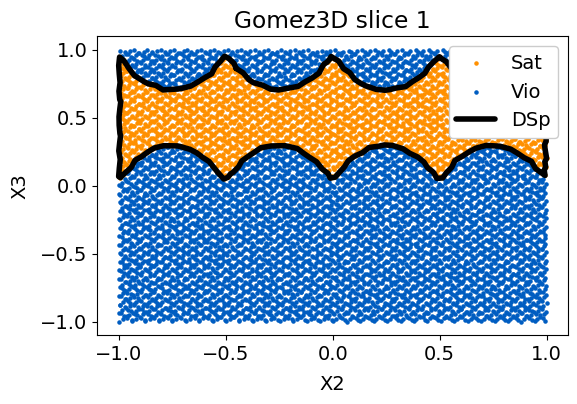

Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |        True        |        3747        |     2.500e+00      
    2     |     1.250e+00      |        True        |        3743        |     1.250e+00      
    3     |     6.250e-01      |        True        |        3687        |     6.250e-01      
    4     |     3.125e-01      |        True        |        3432        |     3.125e-01      
    5     |     1.562e-01      |        True        |        1619        |     1.562e-01      
    6     |     7.812e-02      |        True        |        925         |     7.812e-02      

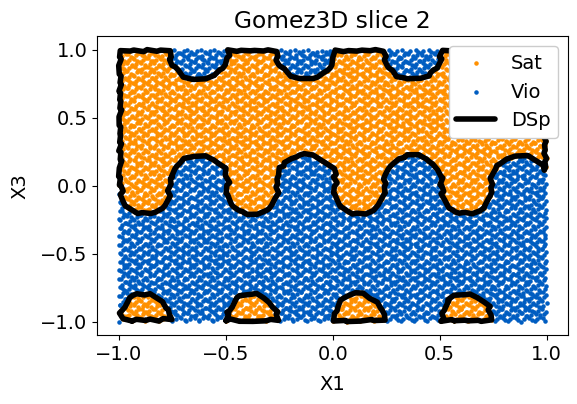

Bisection search for alpha multiplier (radius)
    tol: 1.00e-03  maxiter: 50
    lb:  1.00e-30  ub:      5.00e+00
    maxvp: 0.00e+00  maxvnum: 0.00
____________________________________________________________________________________________
 No iter  |  alpha multiplier  |   Violation Flag   | Number vio inside  |   Bisection Gap    
____________________________________________________________________________________________
    1     |     2.500e+00      |        True        |        5636        |     2.500e+00      
    2     |     1.250e+00      |        True        |        5632        |     1.250e+00      
    3     |     6.250e-01      |        True        |        5628        |     6.250e-01      
    4     |     3.125e-01      |        True        |        5589        |     3.125e-01      
    5     |     1.562e-01      |        True        |        5488        |     1.562e-01      
    6     |     7.812e-02      |        True        |        702         |     7.812e-02      

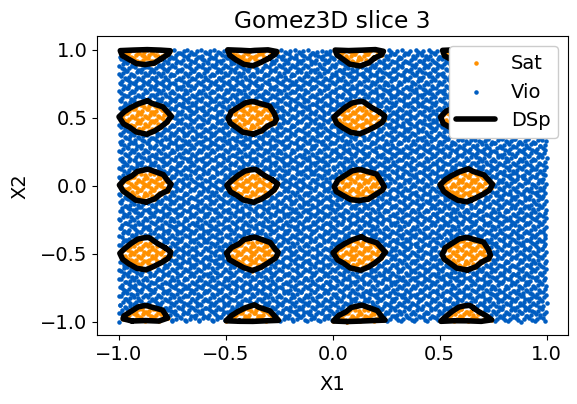

In [26]:
#plotting the results of DSp
benchmark_sol_3DGP = load_pkl('benchmark_sol_3DGP.pkl')

for problem_label in ['Gomez3D']:
    for no_slice in range(len(list(benchmark_sol_3DGP[problem_label].keys()))):
        opt_hidedsp = {'hidedsp': False, 'hidevio': False}
        ds = benchmark_sol_3DGP[problem_label][no_slice]
        sv = ds.df['sv_cut'].iloc[0]
        ds.plot(sv, opt = opt_hidedsp)
        plt.title(problem_label + ' slice ' + str(no_slice+1))
        plt.show()